# Classification with TensorFlow Neural Decision Forests

## The scenario

Predicting sepsis from patient data.

## The data

This example uses synthetically generated patient data containing biological markers. The task is binary classification to predict whether a patient is septic or not based on bio-markers. The dataset includes 100,000 instances with 4 numerical features (Heart Rate, Respiratory Rate, Temperature, and White Blood Cell Count) labelled with 0 (not septic) or 1 (septic).

For more details review the data_file folder.

## The model

TensorFlow Decision Forests (TF-DF).

# Development & Training

## Install packages and libraries

In the terminal run 'pip install -r requirements.txt'. Import libraries needed for development.

In [6]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

# data splitting
from sklearn.model_selection import train_test_split

In [7]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v0.2.7


## Load the data 

In [8]:
# Download the dataset into a Pandas Dataframe.
# if you have a patient id you can append index_col=0 to exclude the id from being trained on
data = pd.read_csv("../data/training_data/septic_data_labelled.csv", sep=",")

# Display the shape
print(f"Dataset shape: {data.shape}")

# Display the first 3 examples.
data.head(3)

Dataset shape: (100000, 5)


,Temp,HR,Resp,WBC,isSeptic
0,40.0,110.0,12.0,4.54,0
1,41.5,79.0,26.0,4.23,0
2,41.9,61.0,14.0,18.13,0


Check the data representation for non-Septic to Septic records.

In [9]:
data['isSeptic'].value_counts()

0    93000
1     7000
Name: isSeptic, dtype: int64

In [10]:
# This stage is necessary if your classification label is represented as a
# string since Keras expects integer classification labels.
# When using `pd_dataframe_to_tf_dataset` (see below), this step can be skipped.

# Name of the label column.
label = "isSeptic"

classes = data[label].unique().tolist()
print(f"Integer classes: {classes}")

Integer classes: [0, 1]


## Split the data

Next split the dataset into training and testing:

In [11]:
# split, shuffle, and stratify the data
train_ds, test_ds = \
    train_test_split(
    # the dataset
    data,
    # how much to split for test
    test_size=0.20,
    # whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
    shuffle=True,
    # random state fixes the randomization so you get the same results each time
    random_state=42, 
    # stratified splitting keeps the proportion of y values trhough the train and test sets
    stratify=data["isSeptic"])

print(f"Train dataset (rows, cols.): {train_ds.shape}")
print(f"Test dataset (rows, cols.): {test_ds.shape}")

Train dataset (rows, cols.): (80000, 5)
Test dataset (rows, cols.): (20000, 5)


In [12]:
# Display the first 3 examples after the split, shuffle and stratification
train_ds.head(3)

,Temp,HR,Resp,WBC,isSeptic
43652,36.5,205.0,24.0,10.36,0
59685,36.4,239.0,17.0,3.12,0
33086,36.7,186.0,18.0,3.83,0


Check that the split data is representative of the population that is septic on average.

In [13]:
train_ds['isSeptic'].value_counts()

0    74400
1     5600
Name: isSeptic, dtype: int64

In [14]:
test_ds['isSeptic'].value_counts()

0    18600
1     1400
Name: isSeptic, dtype: int64

## Convert the data

And finally, convert the pandas dataframe (pd.Dataframe) into tensorflow datasets (tf.data.Dataset). 

In [15]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds, label=label)

/opt/app-root/lib64/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
2022-10-17 16:17:25.941106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-17 16:17:25.941154: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-17 16:17:25.941195: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub-nb-opentlc-2dmgr): /proc/driver/nvidia/version does not exist
2022-10-17 16:17:25.945236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)

## Train the model

Notes for training:
-  No input features are specified. Therefore, all the columns will be used as input features except for the label. The feature used by the model are shown in the training logs and in the model.summary().
- DFs consume natively numerical, categorical, categorical-set features and missing-values. Numerical features do not need to be normalized. Categorical string values do not need to be encoded in a dictionary.
- No training hyper-parameters are specified. Therefore the default hyper-parameters will be used. Default hyper-parameters provide reasonable results in most situations.
- Calling compile on the model before the fit is optional. Compile can be used to provide extra evaluation metrics.
- Training algorithms do not need validation datasets. If a validation dataset is provided, it will only be used to show metrics.
- Add a verbose argument to RandomForestModel to control the amount of displayed training logs. Set verbose=0 to hide most of the logs. Set verbose=2 to show all the logs.

In [16]:
# Specify the model.
model = tfdf.keras.RandomForestModel()

# other optional forest models available
#model = tfdf.keras.GradientBoostedTreesModel(num_trees=1500)
#model = tfdf.keras.CartModel

# Train the model.
model.fit(x=train_ds)

Use /tmp/tmp_94y5wif as temporary training directory
Reading training dataset...
Training dataset read in 0:00:09.201428. Found 80000 examples.
Training model...


[INFO kernel.cc:1176] Loading model from path /tmp/tmp_94y5wif/model/ with prefix b898dd0e067e4e80


Model trained in 0:00:26.006942
Compiling model...


[INFO abstract_model.cc:1248] Engine "RandomForestOptPred" built
[INFO kernel.cc:1022] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Analyze the model
The overall structure of the model is show with `.summary().` You will see:

- Type: The learning algorithm used to train the model (Random Forest in our case).
- Task: The problem solved by the model (Classification in our case).
- Input Features: The input features of the model.
- Variable Importance: Different measures of the importance of each feature for the model.
- Out-of-bag evaluation: The out-of-bag evaluation of the model. This is a cheap and efficient alternative to cross-validation.
- Number of {trees, nodes} and other metrics: Statistics about the structure of the decisions forests.
- Remark: The summary's content depends on the learning algorithm (e.g. Out-of-bag is only available for Random Forest) and the hyper-parameters (e.g. the mean-decrease-in-accuracy variable importance can be disabled in the hyper-parameters).

In [17]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (4):
	HR
	Resp
	Temp
	WBC

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL" 10.751950 ################
    2.     "WBC"  3.359440 ####
    3.    "Resp"  3.113238 ####
    4.      "HR"  1.925978 ##
    5.    "Temp"  0.369735 

Variable Importance: NUM_AS_ROOT:
    1. "Temp" 229.000000 ################
    2.   "HR" 71.000000 

Variable Importance: NUM_NODES:
    1.  "WBC" 23497.000000 ################
    2.   "HR" 15647.000000 ########
    3. "Temp" 10736.000000 ###
    4. "Resp" 7004.000000 

Variable Importance: SUM_SCORE:
    1.  "WBC" 2002227.376095 ################
    2. "Resp" 1855349.446625 #############


Plotting of decision forest models.

The root node on the left contains the first condition (HR >= 38.5500), number of examples (80000) and label distribution (the red-blue-green bar).

Examples that evaluates true to WBC >= 11.9850 are branched to the green path. The other ones are branched to the red path.

The deeper the node, the more pure they become i.e. the label distribution is biased toward a subset of classes.

In this tree:
- The colors red represents not septic (0) and blue represents septic (1).
- The first decision is based on HR. 
- As you move further into the forest, look for the decision where the blue (Septic) records becomes more obvious.

In [18]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=4)

This dataset is small. You can see the model converging almost immediately.

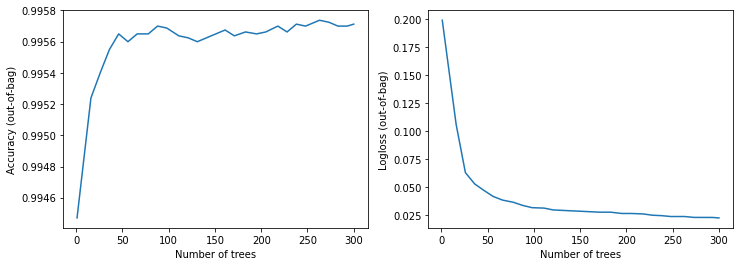

In [19]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

## Evaluate the model

Let's evaluate our model on the test dataset.

In [20]:
model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

20/20 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - accuracy: 0.9952

loss: 0.0000
accuracy: 0.9952


Remark: The test accuracy (`0.9953`) is close to the Out-of-bag accuracy (`0.995613`) shown in the training logs.

## Prepare this model for TensorFlow Serving.

Export the model to the SavedModel format for later re-use e.g. TensorFlow Serving.

In [21]:
# Model versioning
# MAJOR.MINOR.PIPELINE
# 1. MAJOR: increases when incompatible data changes, schema or target variable change, that renders model incompatible when used for predictions
# 2. MINOR: increases when model performance is improved
# 3. PIPELINE: correspond to an update to training pipeline but may not change the model itself

model.save("01_manual_ml/models/sepsis_tfdf")

INFO:tensorflow:Assets written to: 01_manual_ml/models/sepsis_tfdf/assets


INFO:tensorflow:Assets written to: 01_manual_ml/models/sepsis_tfdf/assets


# Demonstrate Prediction

A sample of new unlabelled data is saved in the data/serving_data directory. 
- contains 21 records with no label
- the first 6 records are not septic (rows 0 through 5)
- the remaining 15 records are septic (rows 6 through 20)

In [22]:
# load the saved model
import keras
sepsis = keras.models.load_model('01_manual_ml/models/sepsis_tfdf')

[INFO kernel.cc:1176] Loading model from path 01_manual_ml/models/sepsis_tfdf/assets/ with prefix b898dd0e067e4e80
[INFO decision_forest.cc:639] Model loaded with 300 root(s), 114068 node(s), and 4 input feature(s).
[INFO kernel.cc:1022] Use fast generic engine


In [24]:
# load the unseen data
df = pd.read_csv('../data/serving_data/septic_data_unlabelled.csv')
df.head(22)

,Temp,HR,Resp,WBC
0,39.52,61.39,13.60,9.98
1,35.50,89.70,13.19,6.11
2,36.87,225.42,13.46,5.16
3,37.41,85.06,23.97,10.95
4,37.56,89.05,17.36,20.76
5,36.20,88.01,19.30,3.07
6,40.87,238.75,16.53,5.73
7,40.18,61.56,23.43,5.65
8,42.09,73.26,19.96,20.62
9,39.87,81.21,16.95,3.65


In [25]:
TFDF = tfdf.keras.pd_dataframe_to_tf_dataset(df)

In [26]:
# run the prediction https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel#predict
predictions = sepsis.predict(TFDF)
# convert the array to a DataFrame
write_predictions = pd.DataFrame(predictions)
# write out
write_predictions.to_csv('./01_manual_ml.csv', index=False)
# CURRENT OUTPUT READS AGAINST 0 (not septic) LABEL
#TODO encode output to be more intuitive

1/1 [==============================] - 0s 88ms/step


In [27]:
write_predictions.head(22)

,0
0,0.999999
1,0.786666
2,0.999999
3,0.999999
4,0.999999
5,0.999999
6,0.000000
7,0.000000
8,0.000000
9,0.000000
